<a href="https://colab.research.google.com/github/KenzaB27/BGNHackathon2021/blob/machine_learning/machine_learning/alphanum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environement setup

In [1]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! pip install -q kaggle

In [4]:
## Upload kaggle API file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quintessence18","key":"6f841359e2a88391f87f96d17c915010"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kuzivakwashe/significant-asl-sign-language-alphabet-dataset
!unzip /content/significant-asl-sign-language-alphabet-dataset.zip -d significant-asl-sign-language-alphabet-dataset

In [8]:
from tensorflow import keras
from tqdm import tqdm
# Imports for Deep Learning
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.models import Sequential, load_model, Model

# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
tf.random.set_seed(2)

# Imports to view data
import cv2
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

# Image Preprocessing
from skimage.filters import sobel, scharr

import os

# Preprocessing

In [9]:
# Set global variables
TRAIN_DIR = '/content/significant-asl-sign-language-alphabet-dataset/significant-asl-alphabet-training-set/Training Set'
TEST_DIR = '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'
# CUSTOM_TEST_DIR = '/content/asl-alphabet-test/asl-alphabet-test/'

IMG_SIZE = 64
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
TARGET_DIMS = (IMG_SIZE, IMG_SIZE, 3) # add channel for RGB
N_CLASSES = 27
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

# Model saving for easier local iterations
MODEL_DIR = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = True


In [10]:
CATEGORIES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CATEGORIES.sort()

print('Following classes were found:')
print(', '.join(CATEGORIES))

Following classes were found:
A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, space


(129, 77, 3)
(152, 80, 3)
(135, 93, 3)
(175, 81, 3)
(150, 129, 3)
(147, 140, 3)
(190, 207, 3)
(126, 115, 3)
(157, 152, 3)
(302, 302, 3)
(160, 89, 3)
(166, 166, 3)
(162, 133, 3)
(163, 87, 3)
(111, 128, 3)
(99, 77, 3)
(106, 107, 3)
(152, 71, 3)
(200, 200, 3)
(153, 101, 3)
(143, 65, 3)
(151, 103, 3)
(167, 85, 3)
(150, 77, 3)
(240, 320, 3)
(200, 200, 3)
(200, 200, 3)


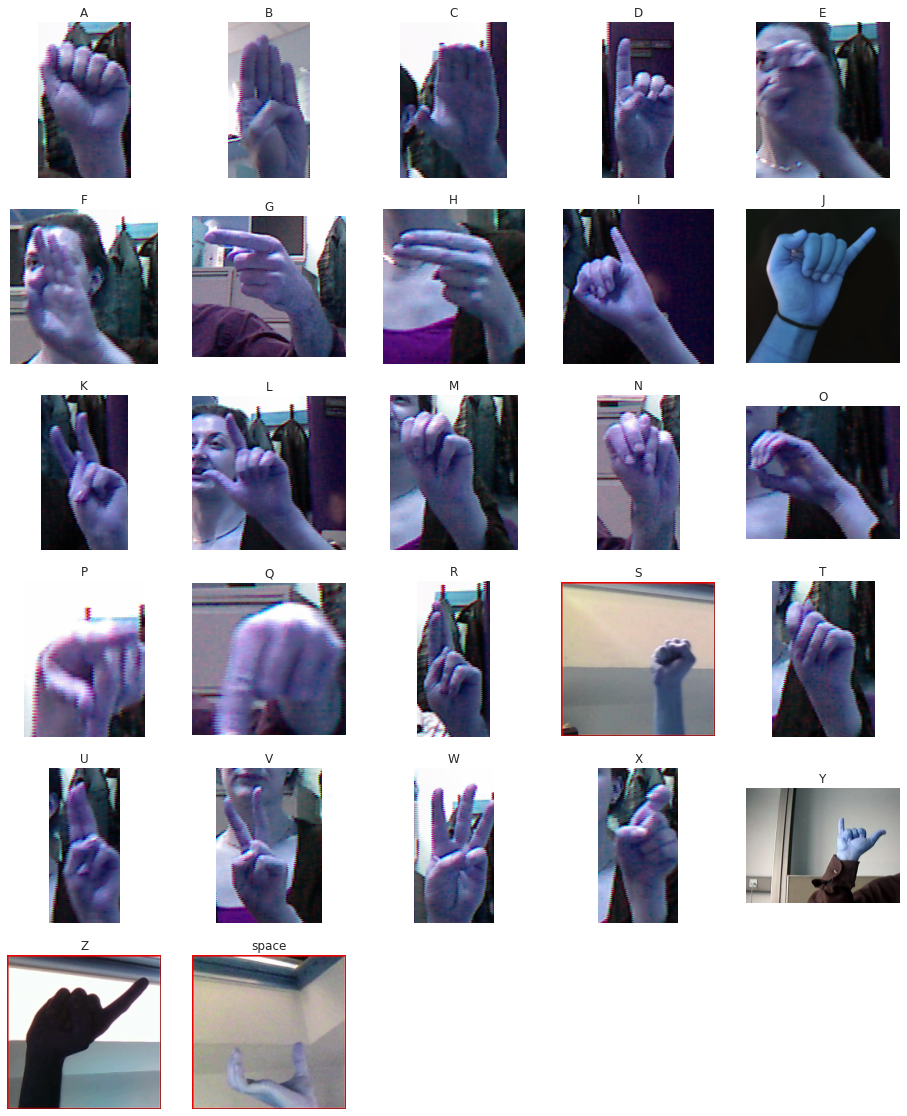

In [11]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CATEGORIES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CATEGORIES)):
        cls = CATEGORIES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        im = cv2.imread(imgs[0])
        print(im.shape)
        plt.imshow(im)
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

plot_one_sample_of_each(TRAIN_DIR)

## Test and Training Data



In [194]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....

        path = os.path.join(TRAIN_DIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
                # print(new_array.shape)
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_training_data() # call function

100%|██████████| 3000/3000 [00:03<00:00, 956.45it/s]


In [195]:
import random
random.shuffle(training_data)

# Check the shuffle
for sample in training_data[:10]:
    print(sample[1])

2
15
25
6
13
10
19
10
0
3


In [196]:
test_data = training_data[76490:]
len(test_data)

1000

In [197]:
training_data = training_data[:76490]
len(training_data)

76490

## Split labels and features

In [198]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

np.save("/content/Kaggle/Working/X.npy", X)
np.save("/content/Kaggle/Working/Y.npy", Y)


(76490, 64, 64, 3)
(76490,)


# Build Model

Need to reprocess? True


In [202]:
# with tpu_strategy.scope():

model = Sequential()

model.add(Conv2D(32,(3,3),padding = 'same',input_shape=TARGET_DIMS,activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(N_CLASSES,activation="softmax"))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [203]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)        

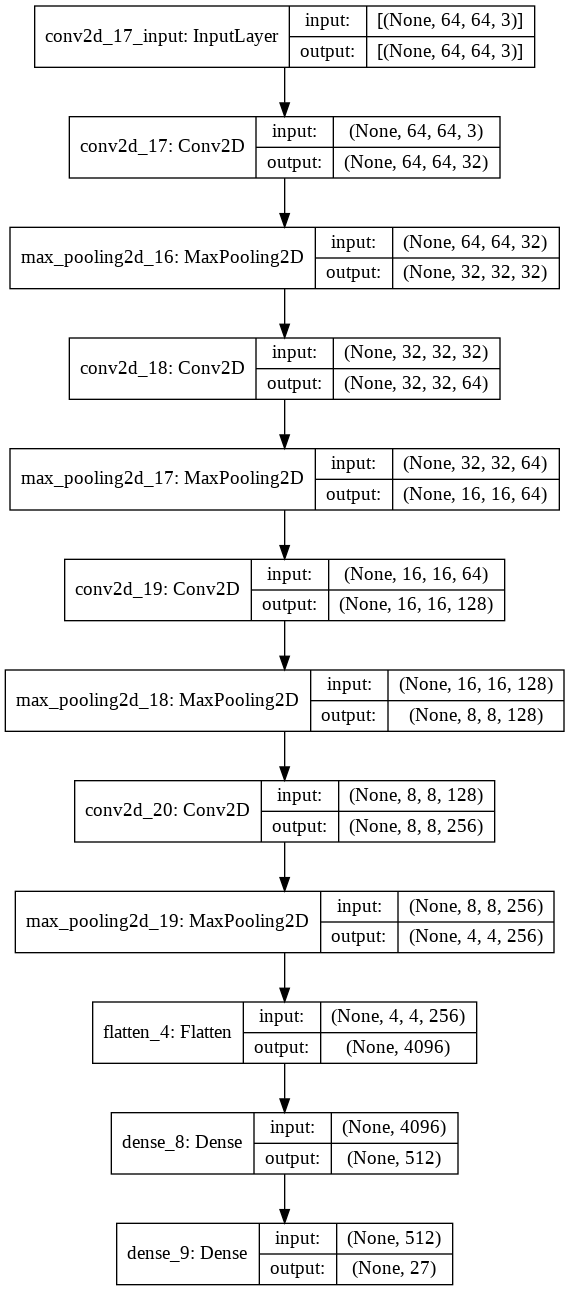

In [204]:
from tensorflow import keras
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [251]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign3.h5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor ='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=5, min_delta=1e-3)
with tf.device('/device:GPU:0'):
  history = model.fit(X, Y, batch_size=32, epochs=20, verbose=1, callbacks=[checkpoint, earlystop], 
                      validation_split=VALIDATION_SPLIT)

Epoch 1/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.0811 - accuracy: 0.9854 - val_loss: 0.2075 - val_accuracy: 0.9774

Epoch 00001: val_accuracy improved from -inf to 0.97745, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign3.h5
Epoch 2/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.0894 - accuracy: 0.9851 - val_loss: 0.2220 - val_accuracy: 0.9746

Epoch 00002: val_accuracy did not improve from 0.97745
Epoch 3/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.1016 - accuracy: 0.9845 - val_loss: 0.3509 - val_accuracy: 0.9644

Epoch 00003: val_accuracy did not improve from 0.97745
Epoch 4/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.1059 - accuracy: 0.9840 - val_loss: 0.2529 - val_accuracy: 0.9747

Epoch 00004: val_accuracy did not improve from 0.97745
Epoch 5/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.1118 - accuracy: 0.9833 - val_lo

In [252]:
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign3.h5'
model.load_weights(checkpoint_filepath)
model.save_weights(checkpoint_filepath)

In [253]:
model.save("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model3")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model3/assets


In [254]:
reconstructed_model = keras.models.load_model("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model3")

In [255]:
reconstructed_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)        

## Evaluate model

In [211]:
len(test_data)

1000

In [256]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)
print(X_test.shape)
print(Y_test.shape)

np.save(MODEL_DIR+"X_test.npy", X_test)
np.save(MODEL_DIR+"Y_test.npy", Y_test)


(1000, 64, 64, 3)
(1000,)


In [257]:
loss,acc = model.evaluate(X_test,Y_test)
print(f"Accuracy: {acc*100}")
print(f"Loss: {loss}")

32/32 [==============================] - 0s 3ms/step - loss: 0.1528 - accuracy: 0.9810
Accuracy: 98.1000006198883
Loss: 0.1528063714504242


In [214]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.976

In [258]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        44
           1       0.98      1.00      0.99        42
           2       0.97      1.00      0.99        37
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        32
           5       1.00      0.98      0.99        43
           6       1.00      0.97      0.99        40
           7       0.98      1.00      0.99        45
           8       1.00      1.00      1.00        45
          10       1.00      1.00      1.00        37
          11       0.95      0.93      0.94        45
          12       1.00      0.97      0.99        39
          13       1.00      1.00      1.00        31
          14       0.98      0.95      0.96        43
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00        26
          17       0.95      0.95      0.95        40
          18       0.97    

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip /content/asl-alphabet.zip -d asl-alphabet

In [ ]:
import cv2
def test_model(path, model):

  im = cv2.imread(path)

  im = cv2.resize(im, (IMG_SIZE,IMG_SIZE))
  im = im.reshape(1,IMG_SIZE,IMG_SIZE,3)

  plt.imshow(im[0])
  plt.show()
  res = model.predict(im)
  return np.argmax(res)

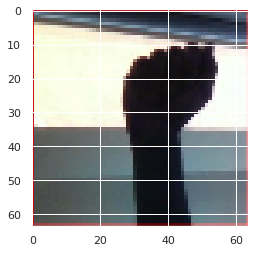

0


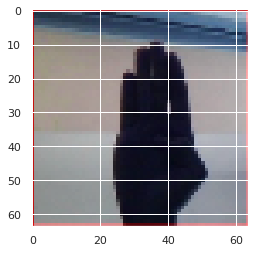

1


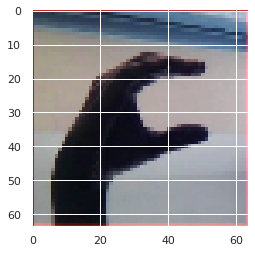

2


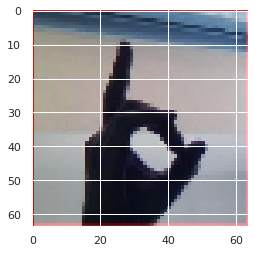

3


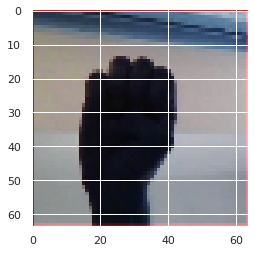

4


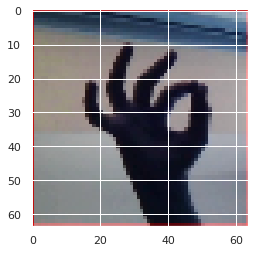

5


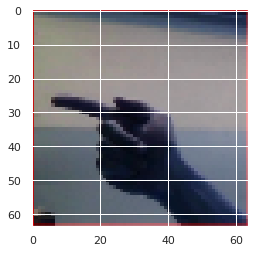

6


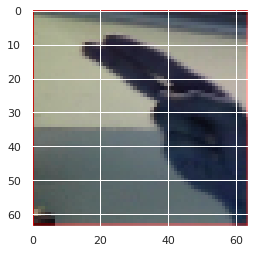

7


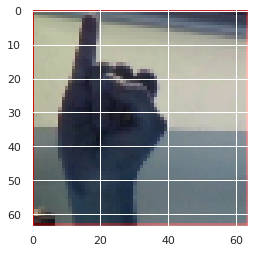

8


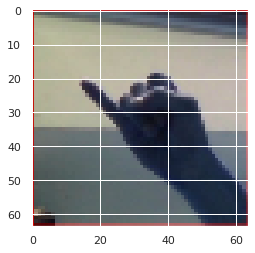

6


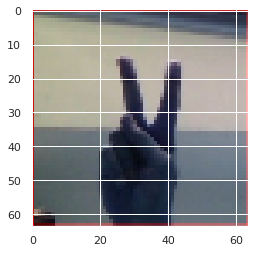

21


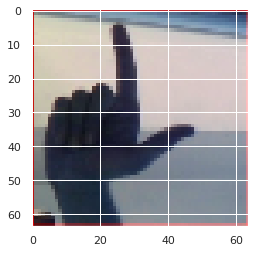

11


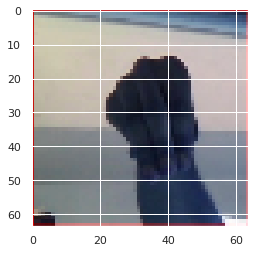

13


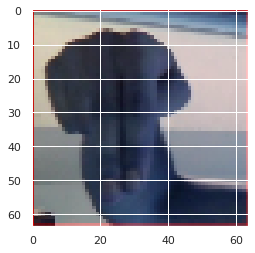

13


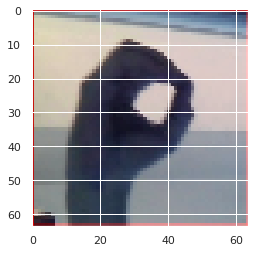

24


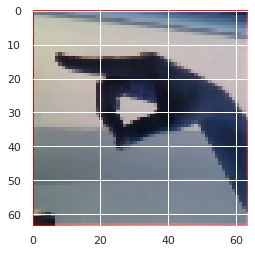

15


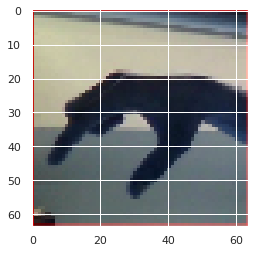

15


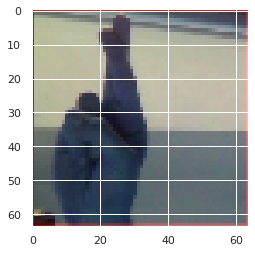

17


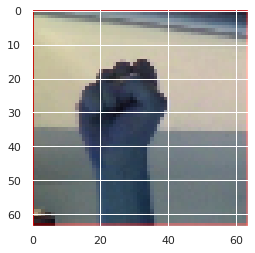

13


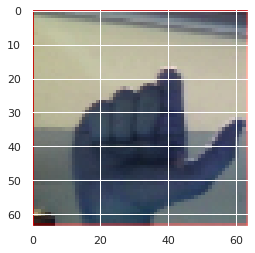

13


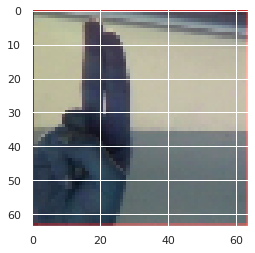

22


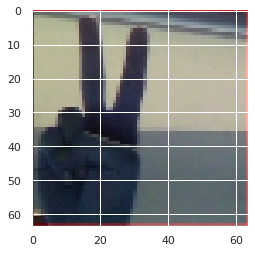

22


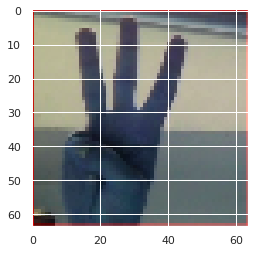

8


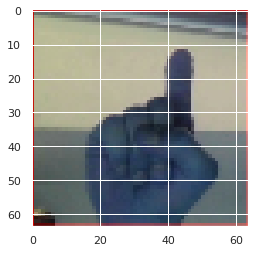

11


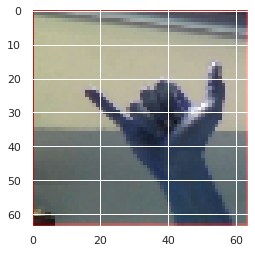

24


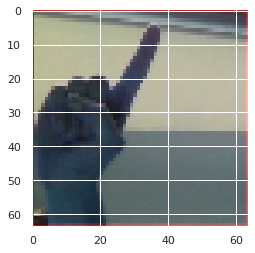

25


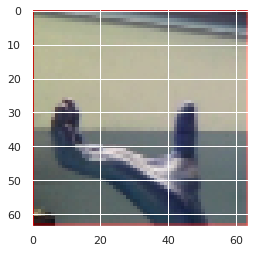

6
15


In [ ]:
count = 0
for i, cat in enumerate(CATEGORIES):
  path = TEST_DIR + cat + "_test.jpg"
  prediction = test_model(path, model)
  if i == prediction: 
    count += 1 
  print(prediction)

print(count)

In [ ]:
model.save

In [267]:
# Let’s extract the keras model
#keras_model = model.keras_model
# Create the TFLite converter with the keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.allow_custom_ops=True
converter.target_spec.supported_ops = [
tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1yp548ts/assets


INFO:tensorflow:Assets written to: /tmp/tmp1yp548ts/assets


In [268]:
# Save the model.
with open('/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite', 'wb') as f:
  f.write(tflite_model)

In [259]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model3") # path to the SavedModel directory
converter.target_spec.supported_ops = [
tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite', 'wb') as f:
  f.write(tflite_model)

In [269]:
# Load TFLite model and allocate tensors.

interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite")
interpreter.allocate_tensors()

In [270]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.get_input_details()

In [271]:
# Test model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.03131826 0.05978464 0.03252776 0.03536698 0.0454707  0.02262839
  0.08332276 0.0418087  0.0966052  0.02290668 0.02007062 0.06820633
  0.02257616 0.03221507 0.0151837  0.03771981 0.04770447 0.04798256
  0.02076693 0.02272798 0.03190528 0.03572435 0.04261175 0.02293989
  0.02425964 0.01054784 0.02511754]]


# Add Metadata to file

## Method 1

https://www.tensorflow.org/lite/convert/metadata#model_information

In [192]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2 
import os

In [43]:
img_array = cv2.imread('/content/significant-asl-alphabet-training-set/Training Set/A/A0 (2).jpg')
img_array

In [158]:
!pip install tflite-support

In [281]:
!python ./metadata_writer_for_image_classifier.py \
    --model_file=/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite \
    --label_file=/content/gdrive/MyDrive/BGNHackathon/alphabet_model/labels.txt \
    --export_directory=/content/gdrive/MyDrive/BGNHackathon/alphabet_model/

2021-03-06 22:48:19.847453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "./metadata_writer_for_image_classifier.py", line 207, in <module>
    app.run(main)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 300, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "./metadata_writer_for_image_classifier.py", line 186, in main
    populator.populate()
  File "./metadata_writer_for_image_classifier.py", line 90, in populate
    self._populate_metadata()
  File "./metadata_writer_for_image_classifier.py", line 165, in _populate_metadata
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_lite_support/metadata/python/metadata.py", line 188, in with_model_file
    return cls(model_file

##Method 2

https://nbviewer.jupyter.org/github/quickgrid/CodeLab/blob/master/tensorflow/TFlite_Object_Detection_Custom_Model_Export_With_Metadata_TF1.ipynb

In [272]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "ASL Identifier"
model_meta.description = ("Localize the most prominent object in the "
                          "image from a set of N categories such as "
                          "trees, animals, food, vehicles, person etc.")
model_meta.version = "v1"
model_meta.author = "OreoShake"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [273]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [274]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(64, 64))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [275]:
labelmap_file = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/labels.txt"


export_model_path = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite"

In [276]:
import os

In [277]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 27 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(labelmap_file)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [278]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta, output_meta, output_meta, output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [279]:
populator = _metadata.MetadataPopulator.with_model_file(export_model_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([labelmap_file])
populator.populate()

ValueError: ignored

##Method 3

In [226]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)        

In [179]:
pip install tflite_support_nightly

In [265]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata

ObjectDetectorWriter = object_detector.MetadataWriter
_MODEL_PATH = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite"
_LABEL_FILE = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/labels.txt"
_SAVE_TO_PATH = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite"

writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [127.5], [127.5], [_LABEL_FILE])
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

# Verify the populated metadata and associated files.
displayer = metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

ValueError: ignored

## Method 4

https://stackoverflow.com/questions/62536149/reshaping-tensorflow-output-tensors


In [9]:
! tflite_convert \ --output_file=model3.tflite \--graph_def_file=tflite_graph.pb \--inference_type=QUANTIZED_UINT8 \--input_shapes=1,64,64,3 \--input_arrays normalized_input_image_tensor \--output_arrays "TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \ --mean_values 128 \--std_dev_values 128 \--allow_custom_ops \--change_concat_input_ranges=false \--allow_nudging_weights_to_use_fast_gemm_kernel=true\--saved_model_dir=/content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model3 \--keras_model_file = /content/gdrive/MyDrive/BGNHackathon/alphabet_model/my_model3/saved_model.pb \--output_file=/content/gdrive/MyDrive/BGNHackathon/alphabet_model/model3.tflite

Traceback (most recent call last):
  File "/usr/local/bin/tflite_convert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/lite/python/tflite_convert.py", line 594, in main
    app.run(main=run_main, argv=sys.argv[:1])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python2.7/dist-packages/absl/app.py", line 300, in run
    _run_main(main, args)
  File "/usr/local/lib/python2.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/lite/python/tflite_convert.py", line 577, in run_main
    _convert_tf2_model(tflite_flags)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/lite/python/tflite_convert.py", line 228, in _convert_tf2_model
    model = keras.models.load_model(flags.keras_model_